<img src="pic.png" width="1000px">

In [47]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import torch.nn as nn
from einops import rearrange
from torchsummary import summary
import torch.optim as optim
import math
from tqdm import tqdm
import cv2
import numpy as np

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class VectorQuantizedVariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, codebook_size):
        """
        input_dim: c * h * w - dimension of input image, must be a square number
        hidden_dim: h - hidden layer dimension
        latent_dim: d - dimension of latent space - the vector depth
        codebook_size: k - number of codebook vectors
        """
        super(VectorQuantizedVariationalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size

        # Check if input_dim is a square number
        assert math.sqrt(input_dim).is_integer(), "Input dimension is not a square number"

        # Width, height must match
        self.image_width = int(math.sqrt(input_dim))
        self.image_height = int(math.sqrt(input_dim))

        self.__setup_encoder()
        self.__setup_decoder()
        self.__setup_codebook()
    
    def __setup_encoder(self):
        self.enc_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.enc_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)

        self.relu = nn.ReLU()

        # Now we have two layers for each vector in latent space (going from hidden_dim to latent_dim)
        self.fc_mu = nn.Linear(self.hidden_dim, self.latent_dim)  # Mean vector
        self.fc_logvar = nn.Linear(self.hidden_dim, self.latent_dim)  # Log-variance vector

    def __setup_decoder(self):
        self.dec_fc1 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.dec_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.dec_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

    def __setup_codebook(self):
        # We don't map X to Y, the codebook is a list of vectors that we will learn (nn.Parameter)
        # The codebook vectors are initialized randomly
        self.codebook = nn.Parameter(torch.randn(self.codebook_size, self.latent_dim))

        # Assert codebook shape - we have k vectors of size d
        assert self.codebook.shape == (self.codebook_size, self.latent_dim)

        # We also want to learn the codebook vectors
        self.codebook.requires_grad = True
    
    def encode(self, x):
        assert x.shape[-3:] == (1, self.image_width, self.image_height)

        x = rearrange(x, 'b c h w -> b (c h w)') # Flatten the input
        x = self.relu(self.enc_fc1(x))
        x = self.relu(self.enc_fc2(x))

        mean = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        # Here we don't return x, we return mean and log_var, this is different to AE
        return mean, log_var
    
    def decode(self, z_q):
        # Assert shape of z_q (batch_size, latent_dim)
        assert z_q.shape[-1] == self.latent_dim

        # Run the layers
        x = self.relu(self.dec_fc1(z_q))
        x = self.relu(self.dec_fc2(x))
        x_hat = torch.sigmoid(self.dec_fc3(x))

        # Reshape the output, we now have c, h, w dimensions (spatial image) instead of flat vectors
        x_hat = rearrange(x_hat, 'b (c h w) -> b c h w', c=1, h=self.image_width, w=self.image_height) 

        return x_hat
    
    def reparameterization(self, mean, var):
        """
        Input: var is log_var**0.5
        Variance is exponential of log_var. 
        """
        # Sampling epsilon is stochastic (random). We sample epsilon from normal distribution
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def quantize(self, z_e):
        """
        z_e: (batch_size, latent_dim)

        Get closest (euclidean distance) codebook vector z_q given z_e
        """
        # Assert shape of z_e (batch, latent_dim)
        assert z_e.shape[-1] == self.latent_dim

        # Initialize z_q, here we will add the vectors one by one (after finding the closest one)
        z_q = torch.zeros(z_e.shape).to(device)

        # For each z_e latent vector (we have batch of latent vectors here, so we traverse in python loop instead) we want to find the closest codebook vector
        for i in range(z_e.shape[0]):
            # Calculate distance between z_e[batch_idx] and codebook vectors...
            a = z_e[i] - self.codebook
            assert a.shape == (self.codebook_size, self.latent_dim)

            # Calculate norm to get distances between z_e[batch_idx] and ALL other codebook vectors (we have self.codebook_size vectors)
            distances = torch.norm(a, dim=1)
            assert distances.shape == (self.codebook_size,)
            
            # Get the index of the closest codebook vector
            min_index = torch.argmin(distances).item()

            # Now we have the index of the closest codebook vector, get the representation vector
            z_q_i = self.codebook[min_index]

            # Add the closest codebook vector to z_q
            z_q[i] = z_q_i

        # Assert shape of z_q (batch_size, latent_dim)
        assert z_q.shape == z_e.shape

        return z_q

    def forward(self, x):
        assert x.shape[-3:] == (1, self.image_width, self.image_height)

        # Encode - instead of latent vector we get mean and log_var and we use the reparameterization trick
        mean, log_var = self.encode(x)

        # Here is the magic of VAE
        z_e = self.reparameterization(mean, torch.exp(0.5 * log_var))

        # Quantize the latent vector
        z_q = self.quantize(z_e)
        
        # Decode
        x_reconstructed = self.decode(z_q)

        # The output image should have the same shape as the input image
        assert x_reconstructed.shape == x.shape

        # Return x hat (and also some other stuff for loss calculation and debugging)
        return x_reconstructed, mean, log_var, z_e, z_q

# Quantization of z_e

To quantisize the z_e we run `torch.norm()` which calculate length of vector.

For instance if `a = torch.tensor([1, 1])` then the length of vector is `sqrt(1^2 + 1^2) = sqrt(2) = 1.4142`

So we do: `torch.norm(z_e - codebook)` which means we measure distance between two vectors.

Then we apply `argmin`: `torch.argmin(torch.norm(z_e - codebook))` to get the index of the closest vector in the codebook.

Finally we get the quantized vector: `codebook[torch.argmin(torch.norm(z_e - codebook))]`

In [50]:
# Transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training
num_epochs = 10

# Model
input_dim = 1* 28 * 28
hidden_dim = 512
latent_dim = 200
codebook_size = 512

model = VectorQuantizedVariationalAutoencoder(input_dim, hidden_dim, latent_dim, codebook_size).to(device)

# Optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [58]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 200]         102,600
            Linear-6                  [-1, 200]         102,600
            Linear-7                  [-1, 512]         102,912
              ReLU-8                  [-1, 512]               0
            Linear-9                  [-1, 512]         262,656
             ReLU-10                  [-1, 512]               0
           Linear-11                  [-1, 784]         402,192
Total params: 1,637,536
Trainable params: 1,637,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    # Reconstruction loss
    recon_loss = nn.BCELoss(reduction='sum')(x_hat, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [52]:
def training_step(images, loss_history, recon_loss_history, kl_divergence_history):
    # Forward pass
    x_hat, mean, log_var, z_e, z_q = model(images)

    # Calculate loss
    loss, recon_loss, kl_loss = loss_function(images, x_hat, mean, log_var)

    # Add all three losses to history
    loss_history.append(loss.item())
    recon_loss_history.append(recon_loss.item())
    kl_divergence_history.append(kl_loss.item())

    return loss

In [53]:
def train(num_epochs):
    loss_history = []
    kl_divergence_history = []
    recon_loss_history = []

    for epoch in range(num_epochs):
        model.train()

        overall_loss = 0

        # Use tqdm for progress tracking
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
            for images, _ in t:
                images = images.to(device)

                # Zero gradients before performing a backward pass
                optimizer.zero_grad() 

                # Perform a forward pass and calculate loss
                loss = training_step(images, loss_history, recon_loss_history, kl_divergence_history)

                # Add loss to overall loss
                overall_loss += loss.item()

                # Propagate the loss backward
                loss.backward() # Compute gradients (of KL + recon losses)
                optimizer.step() # Adjust weights of the model

        print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {np.mean(recon_loss_history).item():.4f}, KL Loss: {np.mean(kl_divergence_history).item():.4f}")
        print("Average loss: ", overall_loss / len(train_loader))

In [54]:
num_epochs = 5
train(num_epochs)

Epoch [1/5]: 100%|██████████| 938/938 [00:28<00:00, 32.74it/s]


Epoch [1/5], Recon Loss: 13430.5064, KL Loss: 0.0385
Average loss:  13430.54487450443


Epoch [2/5]: 100%|██████████| 938/938 [00:27<00:00, 33.88it/s]


Epoch [2/5], Recon Loss: 13346.3858, KL Loss: 0.0193
Average loss:  13262.2651596232


Epoch [3/5]: 100%|██████████| 938/938 [00:27<00:00, 33.79it/s]


Epoch [3/5], Recon Loss: 13310.2158, KL Loss: 0.0129
Average loss:  13237.875842779684


Epoch [4/5]: 100%|██████████| 938/938 [00:28<00:00, 33.09it/s]


Epoch [4/5], Recon Loss: 13288.5686, KL Loss: 0.0097
Average loss:  13223.627032770022


Epoch [5/5]: 100%|██████████| 938/938 [00:29<00:00, 31.37it/s]

Epoch [5/5], Recon Loss: 13272.9397, KL Loss: 0.0078
Average loss:  13210.424223747335


In [55]:
# Save the model
torch.save(model, "without_ste.pth")

torch.Size([8, 1, 28, 28])


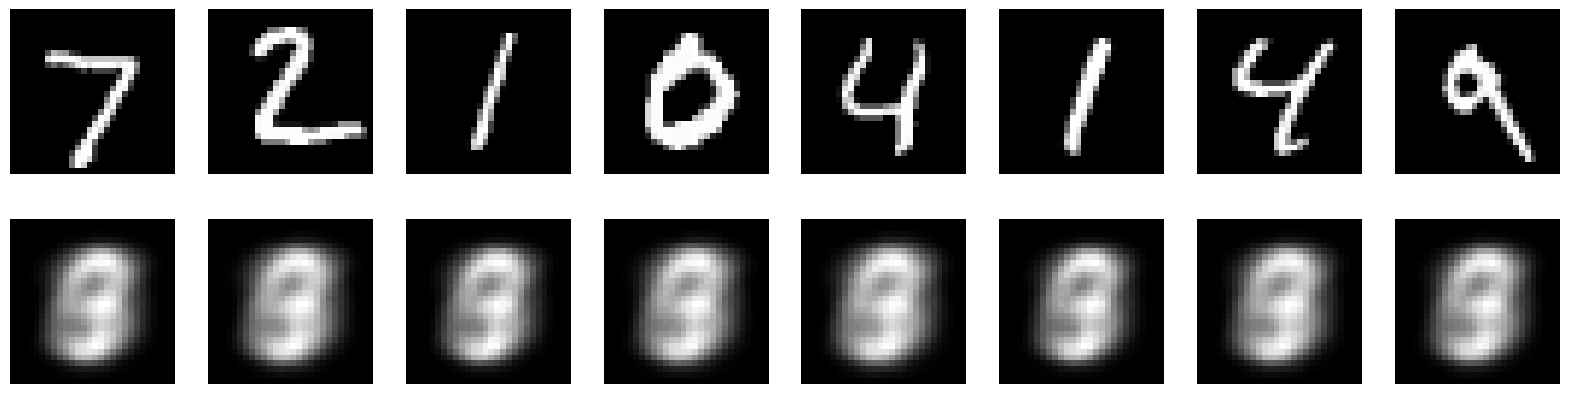

In [56]:
# Plot 8 images (original image) and to their right plot the reconstructed image
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images[:8].to(device)

    outputs, _, _, _, _ = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    print(outputs.shape)

    fig, axes = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(8):
        axes[0, i].imshow(images[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')

    plt.show()

In [57]:
z_e.requires_grad

NameError: name 'z_e' is not defined